# Covid19 spreading in a networking model (part II)

## Introduction

This notebook is the second part of our analysis of how air traffic may have contributed to spread the Covid19 virus. In the previous part, we did a visual analysis of the OpenFlights dataset and showed how to plot geo data with Plotly. Then, we run a first intro to graph-tool and SIR modelling. In this part, we use tools such as Numpy, Pandas, Plotly, and [graph-tool](graph-tool.skewed.de) to run our own SIR pandemic model and learn how to leverage available data to improve our graph based models.

**Note:** we assume you are familiar with the previous part of this notebook. If not, please check it out before continuing.


## Dataset

The [OpenFlights](https://openflights.org/data.html) dataset contains airlines, air routes and airports per country. The information contained in the dataset is up to 2014. This may be a bit outdated. However, it is detailed enough for our purposes.

Additionally, we use the [Kraggle Covid19 challenge](https://www.kaggle.com/c/covid19-global-forecasting-week-2) data as we did in our previous Covid19 series.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import datetime

In [2]:
routes_dataset_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat'
airports_dataset_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat'
countries_dataset_url = 'https://raw.githubusercontent.com/jpatokal/openflights/master/data/countries.dat'


# Load the file with the routes
routes = pd.read_csv(routes_dataset_url, names=['Airline','AirlineID','SourceAirport', 
                                                       'SourceAirportID', 'DestinationAirport', 'DestinationAirportID',
                                                      'CodeShare','Stops','Equipment'], 
                     na_values='\\N')


# Load the file with the airports
airports = pd.read_csv(airports_dataset_url, names=['AirportID','Name','City','Country','IATA','ICAO',
                                                         'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',
                                                         'TzDatabaseTimeZone', 'Type', 'Source'], index_col='AirportID',
                      na_values='\\N')


# Covid19 data
covid_data = pd.read_csv('covid19-global-forecasting-week-2/train.csv',parse_dates=['Date'], 
                   date_parser=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))


In [3]:
# We compute some intermediate dataframes that will be useful later

# Aggregate the number of flights per airport.
# Source_airport -> destination_airport, number of flights
flights_airport = routes.groupby(['SourceAirportID','DestinationAirportID']).size().reset_index(name='num_flights')

# Get the countries for the previous airport IDs
flights_country=flights_airport.join(airports.Country,on='SourceAirportID',lsuffix='Source').\
                join(airports.Country,on='DestinationAirportID',lsuffix='Destination')[['Country','CountryDestination','num_flights']]

# Aggregate the number of flights between countries
# SourceCountry -> DestinationCountry, number of flights
paths = flights_country.groupby(['Country','CountryDestination']).sum()
# Aggregate the number of flights to other countries.
paths_other_countries = flights_country[flights_country.Country != flights_country.CountryDestination].groupby(['Country','CountryDestination']).sum()

# Total number of flights per country
total_flights_country = paths.groupby(['Country']).sum()
# Total number of flights to other countries
total_flights_other_countries = paths_other_countries.groupby(['Country']).sum()


## Air traffic network

As we did in the previous part of this notebook, we create a directed graph $G(V,E)$ where the set of vertices $V$ represents the countries and the set of edges $E$ represents existing air routes from country $A$ to $B$ for every $E(A,B)$. For additional purposes, we set weights $W(E)$ with the number of flights from $A$ to $B$. We also set a vertex value with with the number of flights for every country.

As we observed in the previous notebook, some countries have a large number of domestic flights. In our graph, this is translated into vertex loops. This may have a relevant impact in the pandemic process, for this reason, we generate graphs with and without loops. We study the differences later.


In [4]:
# Run this to ensure that the drawing module is correctly stablished
from graph_tool.all import *
import graph_tool as gt

In [5]:
def generate_graph(list_countries, self_loops=False):
    '''
    Generate the graph for a list of countries indicating if using loops or not.
    The generated output is a graph with:
    vertex property "country" with the country every vertex represents
    vertex property "out_flights" with the number of outgoing flights from a country
    edge property "num_flights" with the number of flights from country A to country B
    
    Finally, the function returns a dictionary with the vertex reference for every country.
    '''
    g = gt.Graph()

    # Create the country property with the country names
    countries_prop = g.new_vertex_property('string')
    g.vertex_properties['country'] = countries_prop

    # Total number of outgoing flights per vertex
    out_flights_prop = g.new_vertex_property('int')
    g.vertex_properties['out_flights'] = out_flights_prop

    # Create edge property with the number of flights between countries
    num_flights_prop = g.new_edge_property('double')
    g.edge_properties['num_flights'] = num_flights_prop

    g.add_vertex(len(list_countries))

    # For a given country, get the vertex
    country_vertex = {}
    index=0

    for c in list_countries:
        v = g.vertex(index)
        index=index+1
        
        countries_prop[v] = c
        country_vertex[c] = v
        # We do not have info for all the countries. Skip when exception
        try:
            if self_loops:
                out_flights_prop[v] = total_flights_country.loc[c]['num_flights']
            else:
                out_flights_prop[v] = total_flights_other_countries.loc[c]['num_flights']
        except:
            out_flights_prop[v] = 0.0
            
        

        
    to_iterate = paths
    if not self_loops:
        to_iterate = paths_other_countries

    # Add the edges
    for index,num_flights in to_iterate.iterrows():
        s = country_vertex[index[0]]
        d = country_vertex[index[1]]
        
        # No self-loops
        if not self_loops and s != d:
            e = g.add_edge(s,d)
            num_flights_prop[e] = num_flights
        else:
            e = g.add_edge(s,d)
            num_flights_prop[e] = num_flights
    
    # link properties to the graph
    g.vertex_properties['country'] = countries_prop
    g.vertex_properties['out_flights'] = out_flights_prop
    g.edge_properties['num_flights'] = num_flights_prop
    
    return g, country_vertex


In [6]:
# load the graph with and without loops

# Get the complete list of countries
list_countries = np.union1d(paths.reset_index().Country.unique(), paths.reset_index().CountryDestination.unique())


g_loops, country_vertex_loops = generate_graph(list_countries,True)
g_noloops, country_vertex_noloops = generate_graph(list_countries,False)

print('With loops -> vertices: %d and edges %d' % (g_loops.num_vertices(), g_loops.num_edges()))
print('Without loops -> vertices: %d and edges %d' % (g_noloops.num_vertices(), g_noloops.num_edges()))

With loops -> vertices: 225 and edges 4697
Without loops -> vertices: 225 and edges 4558


## SIR epidemic process

The [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) model is a simple, yet powerful, compartimental model for epidemics. The model consists of three compartments $S$, $I$ and $R$. $S$ is the number of susceptible, $I$ the number of infectuous and $R$ the number of recovered or deceased individuals. This is the most common model used right now and has many extensions and enhancements. The number of individuals in $S$ falls down as they become infected ($I$) and then recovered $R$. This is one of the famous infection curves used to forecast Covid19 evolution.

This model is particularly suitable for graphs. Edges determine transmission channels to propagate a contagious entity. Vertices transitions between the different compartments modeling the behaviour of pandemics. Using our graph, we assume that air traffic is a potential channel for contagious actors. The larger number of flights between two countries, the higher probabilities of a country to become infected.

As we presented in the previous notebook, graph-tool comes with an implementation of the SIR model easily configurable. We are going to explore four different scenarios combining our graph with an enhanced version using our air traffic information.

| Name |Loops | Airtraffic |
|---|---|---|
|BasicA   | No | No  |
|BasicB   | Yes  | No  |
| EnhA   | No  | Yes  |
| EnhB  | Yes  | Yes   |

The idea is to understand if domestic flights have an impact in the pandemia and whether we can get a better solution enhancing the graph with detailed air traffic data.

We create a helping function called `runSIR` that iterates the SIR model and collects information in a Pandas dataframe. Before that, we add a susceptible vertex property and a beta property to our graphs. The first property, is set to 0 for all the vertices but the root in the pandemia, in this case China. The beta property is a probability computed by dividing $W(E)$ by the total number of outgoing flights for the source vertex of $E$.

In [7]:

def runSIR(g,state,num_iter=100):
    '''
    For a graph tool epidemic model run the state and return a dataframe with the countries infected in every step
    '''
    infections = pd.DataFrame()
    
    previous = state.get_state().fa
    initial = np.where(previous==1)[0]
    
    countries_prop=g.vertex_properties['country']
    
    for t in range(num_iter):
        ret=state.iterate_sync()
        new = state.get_state().fa
        # Find new infected countries
        diff = new - previous
        already_infected = state.get_state().fa.sum()
        non_infected = len(state.get_state().fa)-already_infected
        new_infected = [countries_prop[g.vertex(v)] for v in np.where(diff==1)[0]]
        previous = new.copy()
        # collect the results in a Pandas friendly way
        infections = infections.append([{'step':t,'infected':already_infected,
                                'new_infected': len(new_infected),'non_infected': non_infected,
                                'new_infected_countries': new_infected}], ignore_index=True)
        
    return infections


In [8]:
def prepare_graph_sir(g, root_vertex):
    
    num_flights = g.edge_properties['num_flights']
    out_flights = g.vertex_properties['out_flights']
    
    # Create an edge property map that can help us to define the beta probability between vertices 
    beta_prop = g.new_edge_property('double')
    for e in g.edges():
        beta_prop[e] = num_flights[e]/out_flights[e.source()]

    # Assume that vertices are not susceptible, except the seed.
    susceptible_prop = g.new_vertex_property('float')
    for v in g.vertices():
       susceptible_prop[v] = 0.0
    susceptible_prop[root_vertex]=1.0
    
    g.vertex_properties['susceptible'] = susceptible_prop
    g.edge_properties['beta'] = beta_prop


In [9]:
# We can set the 

prepare_graph_sir(g_loops, country_vertex_loops['China'])
prepare_graph_sir(g_noloops, country_vertex_noloops['China'])

# For the basic version, we set a fixed beta 0.03
basicA_state = gt.dynamics.SIRSState(g_loops, beta=0.03,v0 = country_vertex_loops['China'], constant_beta=True,gamma=0,
                              r=0, s=g_loops.vertex_properties['susceptible'],mu=0,epsilon=0)

basicB_state = gt.dynamics.SIRSState(g_noloops, beta=0.03,v0 = country_vertex_noloops['China'], constant_beta=True,gamma=0,
                              r=0, s=g_noloops.vertex_properties['susceptible'],mu=0,epsilon=0)

enhA_state = gt.dynamics.SIRSState(g_loops, beta=g_loops.edge_properties['beta'],v0 = country_vertex_loops['China'], constant_beta=True,gamma=0,
                              r=0,s=g_loops.vertex_properties['susceptible'],mu=0,epsilon=0)




enhB_state = gt.dynamics.SIRSState(g_noloops, beta=g_noloops.edge_properties['beta'],v0 = country_vertex_noloops['China'], constant_beta=True,gamma=0,
                              r=0,s=g_noloops.vertex_properties['susceptible'],mu=0,epsilon=0)

# We set the number of iterations to 64, to compare with the original Covid19 data. We choose 64, because this is the
# number of days elapsed until all the countries have at least one Covid19 case declared.
basicA = runSIR(g_loops,basicA_state,64)
basicB = runSIR(g_noloops,basicB_state,64)
enhA = runSIR(g_loops,enhA_state,64)
enhB = runSIR(g_noloops,enhB_state,64)

print('BasicA (loops, no airtraffic)')
display(basicA[basicA.new_infected>0].head(5))
print('BasicB (no loops, no airtraffic)')
display(basicB[basicB.new_infected>0].head(5))
print('EnhA (loops, airtraffic)')
display(enhA[enhA.new_infected>0].head(5))
print('EnhB (no loops, airtraffic)')
display(enhB[enhB.new_infected>0].head(5))

BasicA (loops, no airtraffic)


,step,infected,new_infected,non_infected,new_infected_countries
0,0,2,1,223,[Kyrgyzstan]
1,1,4,2,221,"[Israel, Mongolia]"
2,2,9,5,216,"[Algeria, Georgia, Iran, Maldives, Turkey]"
3,3,13,4,212,"[Belgium, Jordan, Nepal, United Arab Emirates]"
4,4,26,13,199,"[Azerbaijan, Bahrain, Czech Republic, Egypt, K..."


BasicB (no loops, no airtraffic)


,step,infected,new_infected,non_infected,new_infected_countries
0,0,5,4,220,"[Finland, Japan, Maldives, Northern Mariana Is..."
1,1,10,5,215,"[Denmark, Kenya, Mexico, Portugal, United King..."
2,2,21,11,204,"[Angola, Cote d'Ivoire, Ghana, Greece, Ireland..."
3,3,47,26,178,"[Armenia, Belgium, Benin, Cameroon, Canada, Eg..."
4,4,71,24,154,"[Bahamas, Bahrain, Burkina Faso, Burundi, Cent..."


EnhA (loops, airtraffic)


,step,infected,new_infected,non_infected,new_infected_countries
4,4,2,1,223,[Kazakhstan]
7,7,3,1,222,[Ukraine]
9,9,4,1,221,[Belarus]
10,10,6,2,219,"[Russia, Spain]"
11,11,10,4,215,"[Austria, Belgium, Greece, Poland]"


EnhB (no loops, airtraffic)


,step,infected,new_infected,non_infected,new_infected_countries
0,0,2,1,223,[Taiwan]
1,1,3,1,222,[Japan]
2,2,4,1,221,[Germany]
3,3,5,1,220,[Hong Kong]
4,4,8,3,217,"[Australia, Thailand, Turkey]"


Only by displaying the first 5 steps of the simulation we observe differences in the evolution of the pandemia. First steps in `BasicA` and `BasicB` infect a larger group of countries when compared with `EnhA` and `EnhB`. Additionally, we expect countries with a larger number of flights coming from China to be infected first. This is not the case with `BasicA` and `BasicB`. Now we can compare it graphically with our original Covid19 dataset.


In [10]:
# Compute the number of infected countries
# Get the first date with confirmed cases for every country
first_date = covid_data[covid_data.ConfirmedCases > 0].groupby('Country_Region', as_index=False).Date.min().sort_values(by='Date')
# Compute the number of elapsed days since the beginning of China's outbreak
first_date['step']=first_date.Date-datetime.datetime(2020,1,22)
# Convert this column into an integer with the number of days.
first_date.step = first_date.step.dt.days
# Get the number of infected countries per region
covid_infected = first_date[['step','Country_Region']].groupby('step').agg(new_infected=('step','count'))
covid_infected['infected'] = covid_infected['new_infected'].cumsum()
covid_infected = covid_infected.reset_index()

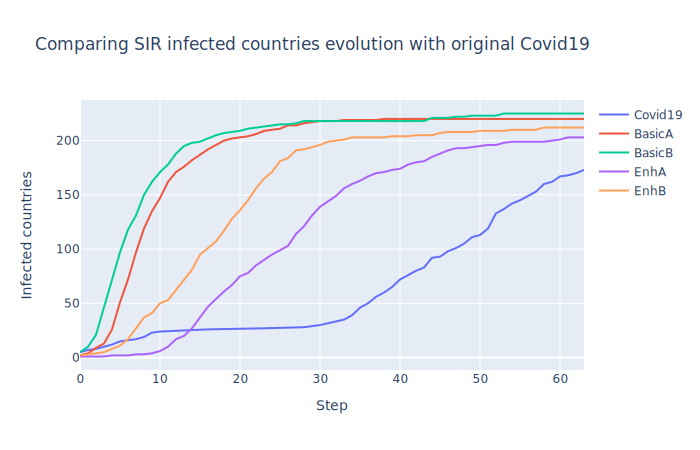

In [11]:
f = go.Figure()
f.add_trace(
    go.Scatter(x=covid_infected.step,y=covid_infected.infected,name='Covid19')
)

f.add_trace(
    go.Scatter(x=basicA.step,y=basicA.infected,name='BasicA')
)

f.add_trace(
    go.Scatter(x=basicB.step,y=basicB.infected,name='BasicB')
)

f.add_trace(
    go.Scatter(x=enhA.step,y=enhA.infected,name='EnhA')
)

f.add_trace(
    go.Scatter(x=enhB.step,y=enhB.infected,name='EnhB')
)

f.update_layout(
    title_text='Comparing SIR infected countries evolution with original Covid19',
    xaxis=dict(title='Step'),
    yaxis=dict(title='Infected countries')
)

f.show(renderer='svg')

There is a relevant distance between the original Covid19 series and our simulations. The original Covid19 has a sustained plateau that is ignored in the simulations. However, `EnhA` is the best approximation to the original series. This shows that there is a relevant impact considering domestic flights (loops in the graph) and air traffic. 


## Order of infection

Using our propagation model we can forecast when a country can be considered to be infected. Assuming that every step in the simulation corresponds to a day in the real Covid19 evolution, we can compute when a country gets infected. Then, we can compute the temporal distance between our simulation and the real observed day the country was declared infected. We consider a country to be infected as soon as it has a declared case of Covid19.

In [12]:
def compute_distances(truth,approx,method):
    distances = pd.DataFrame()
    for row in approx.iterrows():
        for c in row[1].new_infected_countries:
            elapsed = truth[truth.Country_Region==c].step.values
            if len(elapsed)!=1:
                continue
            elapsed = elapsed[0]
            distances = distances.append(
                [{'country':c,'truth': elapsed,'approx':row[1].step,'distance':elapsed-row[1].step,'method':method}],
            ignore_index=True)
    return distances

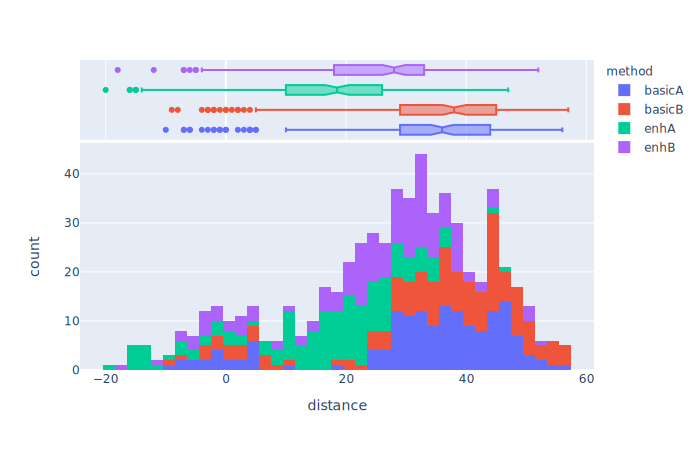

In [13]:
distances = compute_distances(first_date,basicA,'basicA')
distances = distances.append(compute_distances(first_date,basicB,'basicB'))
distances = distances.append(compute_distances(first_date,enhA,'enhA'))
distances = distances.append(compute_distances(first_date,enhB,'enhB'))

fig = px.histogram(distances,'distance',nbins=60,color='method',marginal='box')
fig.show(renderer='svg')

The histogram above shows the temporal distance for the countries to get infected in our four scenarios. The temporal distance is the difference between the day a country declared at least one infected and the day this country appears as infected in our simulations. Positive distances indicate that our simulations predicted an infection later than it was observed. And the other way around, negative distances indicate predictions before the infection was observed.

Our models predict infected countries with an important delay. However, `enhA` outperforms the other methods. The marginal boxes indicate a distribution closer to 0 than the others. This demonstrates that leveraging air traffic have a positive impact in the performance of the SIR model.


# Conclusions

In this notebook, we have explored how we can enhance a network dissemination model with SIR and air traffic data. Our results, far from being perfect, demonstrate how networks enhanced with additional data can improve dissemination models. In particular, we demonstrate that using air traffic data may have a relevant impact in the understanding and performance of existing Covid19 models. 



# References

Tiago P. Peixoto, “The graph-tool python library”, figshare. (2014) [DOI: 10.6084/m9.figshare.1164194](https://dx.doi.org/10.6084/m9.figshare.1164194) [sci-hub](https://sci-hub.tw/10.6084/m9.figshare.1164194)